In [1]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
from dash.dependencies import Input, Output
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
rcParams['font.family'] = 'sans-serif'
plt.style.use('ggplot')

# dataloading
df = pd.read_csv('Results_21Mar2022.csv')

# preprocessing
def preprocess_data(df):
    # Unify the names of the eating groups
    df['diet_group'] = (
        df['diet_group']
        .str.lower()
        .str.replace(' ', '_')
        .replace({
            'meat': 'meat_100+',
            'meat50': 'meat_50-99',
            'meat<50': 'meat_<50',
            'meat_50': 'meat_50-99',  # replace another possible features
            'meat100': 'meat_100+'
        })
    )
    # 新增饮食组数值编码
    df['diet_code'] = df['diet_group'].astype('category').cat.codes
    # Order age
    # 处理年龄组
    age_order = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
    df['age_group'] = pd.Categorical(df['age_group'], categories=age_order, ordered=True)
    
    # 新增数值型年龄字段（强制转换为整数）
    age_bins = {
        '20-29': 25, '30-39': 35, '40-49': 45,
        '50-59': 55, '60-69': 65, '70-79': 75
    }
    df['age_numeric'] = df['age_group'].map(age_bins).astype(int)  # 关键修复点
    
    # 确保无缺失值
    if df['age_numeric'].isnull().any():
        raise ValueError("存在未处理的年龄组: {}".format(
            df.loc[df['age_numeric'].isnull(), 'age_group'].unique()
        ))

# 验证字段类型
    assert pd.api.types.is_integer_dtype(df['age_numeric']), "age_numeric 必须是整数类型"
    # Key Indicator Selection
    metrics = ['mean_ghgs', 'mean_land', 'mean_watscar', 'mean_eut']
    return df[['diet_group', 'sex', 'age_group', 'n_participants'] + metrics]

df_clean = preprocess_data(df)

# 1. Analysis of environmental indicators
env_metrics = ['mean_ghgs', 'mean_land', 'mean_watscar']
env_df = df_clean.groupby('diet_group')[env_metrics].mean().reset_index()

In [3]:
assert 'age_numeric' in df.columns, "缺失数值型年龄字段"
print(f"数值型年龄范围: {df['age_numeric'].min()}~{df['age_numeric'].max()}")

数值型年龄范围: 25~75


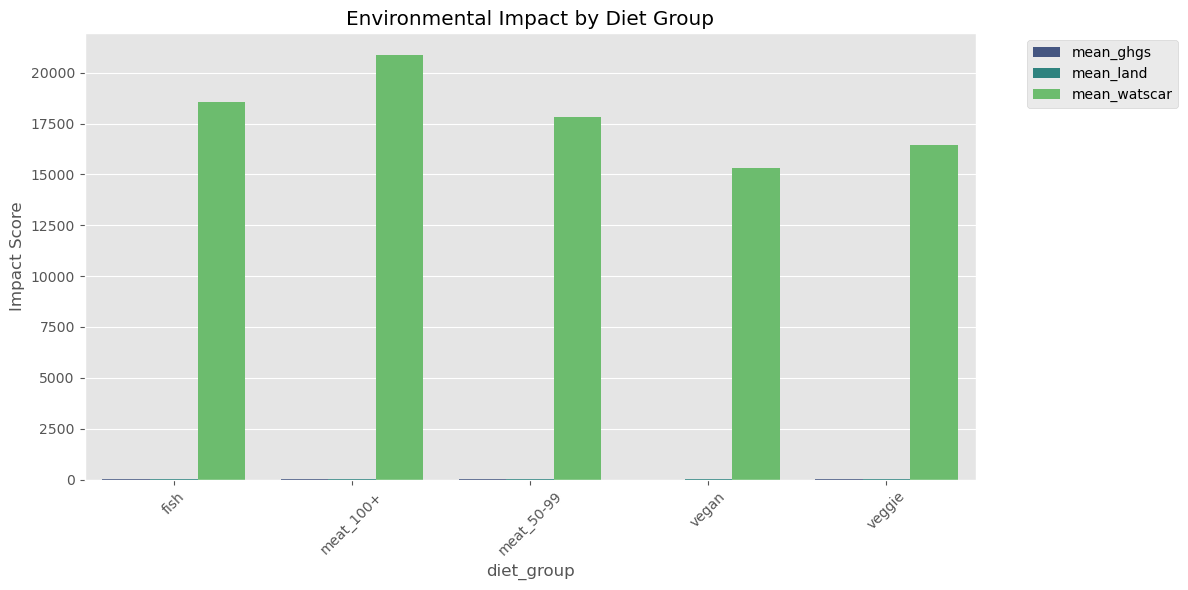

In [4]:
# dv
def plot_environmental_impact(df):
    plt.figure(figsize=(12, 6))
    melted_df = df.melt(id_vars='diet_group', var_name='metric', value_name='value')
    sns.barplot(x='diet_group', y='value', hue='metric', data=melted_df, palette='viridis')
    plt.title('Environmental Impact by Diet Group')
    plt.ylabel('Impact Score')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_environmental_impact(env_df)

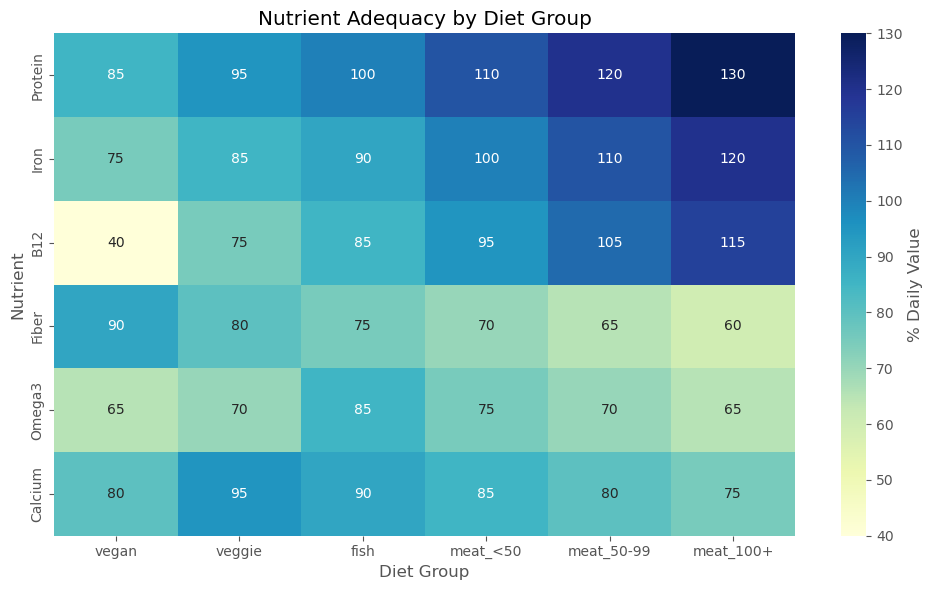

In [5]:
# 2. Nutrition simulation data generation
np.random.seed(42)
nutrient_scores = {
    'vegan': [85, 75, 40, 90, 65, 80],
    'veggie': [95, 85, 75, 80, 70, 95],
    'fish': [100, 90, 85, 75, 85, 90],
    'meat_<50': [110, 100, 95, 70, 75, 85], 
    'meat_50-99': [120, 110, 105, 65, 70, 80],
    'meat_100+': [130, 120, 115, 60, 65, 75]
}
nutrient_df = pd.DataFrame(nutrient_scores).T
nutrient_df.columns = ['Protein', 'Iron', 'B12', 'Fiber', 'Omega3', 'Calcium']

# Nutritional heat map
plt.figure(figsize=(10, 6))
sns.heatmap(nutrient_df.T, annot=True, cmap='YlGnBu', fmt='d',
            cbar_kws={'label': '% Daily Value'})
plt.title('Nutrient Adequacy by Diet Group')
plt.xlabel('Diet Group')
plt.ylabel('Nutrient')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

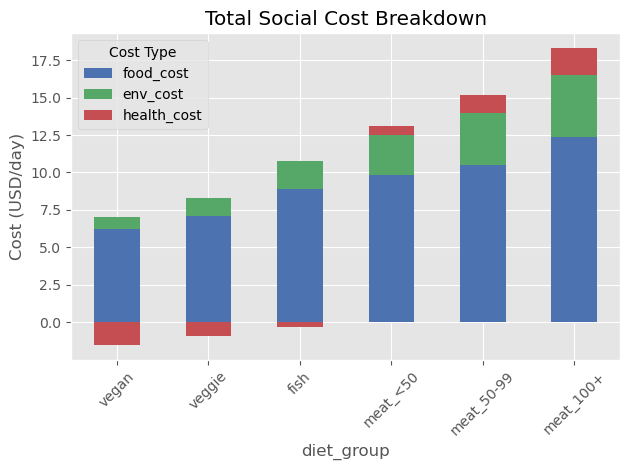

In [6]:
# 3. Economic cost analysis
cost_data = {
    'diet_group': ['vegan', 'veggie', 'fish', 'meat_<50', 'meat_50-99', 'meat_100+'],
    'food_cost': [6.2, 7.1, 8.9, 9.8, 10.5, 12.4],
    'env_cost': [0.8, 1.2, 1.9, 2.7, 3.5, 4.1],
    'health_cost': [-1.5, -0.9, -0.3, 0.6, 1.2, 1.8]
}
cost_df = pd.DataFrame(cost_data)

# Cost exploded chart
plt.figure(figsize=(10, 6))
cost_df.set_index('diet_group').plot(kind='bar', stacked=True, 
color=['#4c72b0', '#55a868', '#c44e52'])
plt.title('Total Social Cost Breakdown')
plt.ylabel('Cost (USD/day)')
plt.xticks(rotation=45)
plt.legend(title='Cost Type')
plt.tight_layout()
plt.show()

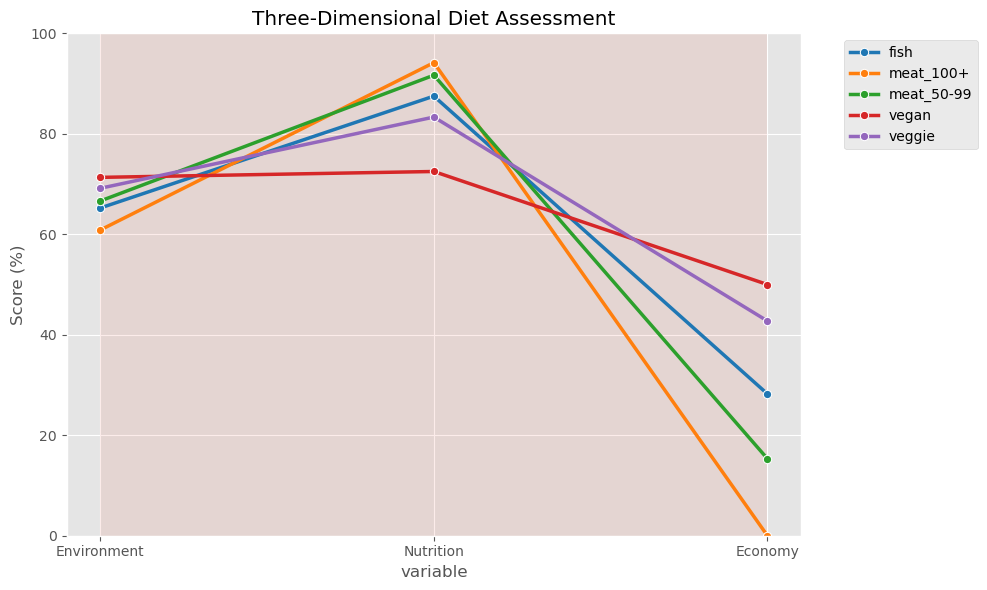

In [7]:
# 4. Three-dimensional comprehensive assessment
def calculate_scores(row):
    env_score = 100 - (row[env_metrics].mean() / env_df[env_metrics].mean().max() * 100)
    nutrient_score = sum(nutrient_scores[row.name]) / 6
    cost_score = 100 - (row['food_cost'] / cost_df['food_cost'].max() * 100)
    return pd.Series([env_score, nutrient_score, cost_score], 
                    index=['Environment', 'Nutrition', 'Economy'])

combo_df = env_df.set_index('diet_group').join(nutrient_df)
combo_df = combo_df.join(cost_df.set_index('diet_group'))
combo_scores = combo_df.apply(calculate_scores, axis=1)

# Redar
labels = combo_scores.columns
values = combo_scores.reset_index().melt(id_vars='diet_group')

plt.figure(figsize=(10, 6))
sns.lineplot(x='variable', y='value', hue='diet_group', data=values,
marker='o', palette='tab10', linewidth=2.5)
plt.fill_between(range(len(labels)), 0, 100, alpha=0.1)
plt.title('Three-Dimensional Diet Assessment')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
plt.xticks(range(len(labels)), labels)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
# # 验证字段类型
# assert pd.api.types.is_integer_dtype(df['age_numeric']), "age_numeric 必须是整数类型"

# # 初始化Dash应用
# app = dash.Dash(__name__)

# app.layout = html.Div([
#     html.H2("Diet Impact Explorer", style={'textAlign': 'center'}),
    
#     html.Div([
#         dcc.Dropdown(
#             id='diet-selector',
#             options=[{'label': d, 'value': d} for d in df['diet_group'].unique()],
#             value=[df['diet_group'].unique()[0]],
#             multi=True
#         )
#     ], style={'width': '60%', 'margin': 'auto'}),
    
#     dcc.Graph(id='main-plot'),
    
#     dcc.Slider(
#         id='age-slider',
#         min=20,
#         max=80,
#         step=10,
#         value=30,
#         marks={age: str(age) for age in range(20, 81, 10)},
#         tooltip={'placement': 'bottom'}
#     )
# ], style={'padding': 20})

# @app.callback(
#     Output('main-plot', 'figure'),
#     [Input('diet-selector', 'value'),
#      Input('age-slider', 'value')]
# )
# def update_plot(selected_diets, selected_age):
#     filtered = df[
#         (df['diet_group'].isin(selected_diets)) & 
#         (df['age_numeric'] >= selected_age) & 
#         (df['age_numeric'] < selected_age + 10)
#     ]
    
#     if filtered.empty:
#         return px.parallel_coordinates(pd.DataFrame(), title="No Data")
    
#     # 创建数值到分类的映射字典
#     diet_mapping = dict(enumerate(filtered['diet_group'].astype('category').cat.categories))
    
#     # 生成图形
#     fig = px.parallel_coordinates(
#         filtered,
#         color="diet_code",
#         dimensions=['mean_ghgs', 'mean_land', 'mean_watscar', 'mean_eut'],
#         color_continuous_scale=px.colors.qualitative.Pastel,
#         labels={m: m.replace('_', ' ').upper() for m in env_metrics}
#     )
    
#     # 更新布局配置颜色轴
#     fig.update_layout(
#         coloraxis_colorbar=dict(
#             title='Diet Group',
#             tickvals=list(diet_mapping.keys()),  # 数值编码
#             ticktext=list(diet_mapping.values()) # 实际分类名称
#         ),
#         plot_bgcolor='#F5F5F5',
#         paper_bgcolor='white',
#         margin={'t': 30}
#     )
    
#     return fig

# if __name__ == '__main__':
#     app.run(debug=True)

In [18]:
print(f"数据集形状: {df.shape}")
print(f"饮食组列表: {df['diet_group'].unique()}")
print(f"年龄字段示例: {df['age_group'].sample(5).values}")

数据集形状: (72000, 24)
饮食组列表: ['fish' 'meat_50-99' 'meat_100+' 'vegan' 'veggie']
年龄字段示例: ['40-49', '60-69', '40-49', '30-39', '60-69']
Categories (6, object): ['20-29' < '30-39' < '40-49' < '50-59' < '60-69' < '70-79']
